# Mask R-CNN for Recycling Object Segmentation

This notebook is adopted from [Russ's Mask R-CNN notebook](https://colab.research.google.com/github/RussTedrake/manipulation/blob/master/segmentation_train.ipynb#scrollTo=xA8sBvuHNNH1).


In [99]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# Need to install old version of numpy because of a conflict with pycocotools
!pip install numpy==1.23.5

# Download TorchVision repo to use some files from
# references/detection
import os
if not os.path.exists('vision'):
    print("Cloning vision")
    !git clone https://github.com/pytorch/vision.git
!cd vision && git checkout main
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/coco_utils.py ./


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/cocodataset/cocoapi.git to /private/var/folders/pp/8jxhzvyn16db7y138w_959180000gn/T/pip-req-build-keadi_uv
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /private/var/folders/pp/8jxhzvyn16db7y138w_959180000gn/T/pip-req-build-keadi_uv
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Already on 'main'
Your branch is up to date with 'origin/main'.


In [100]:
import fnmatch
import json
import numpy as np
import multiprocessing
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data
from torchvision import transforms

# Cannot have a label at index 0 as that means free space
classes = ["empty", "bottle", "Banana", "coffee"]

# Loading dataset into PyTorch

In [101]:
dataset_path = "/tmp/clutter_maskrcnn_data"
if not os.path.exists(dataset_path):
    raise FileExistsError("Dataset not found. Please run make_training_data.ipynb first.")

In [102]:
class RecyclingDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        self.num_images = len(fnmatch.filter(os.listdir(path),'*.png'))

    def __getitem__(self, idx):
        filename_base = os.path.join(self.path, f"{idx:04d}")

        # load image and mask
        img = Image.open(filename_base + ".png").convert("RGB")
        mask = np.squeeze(np.load(filename_base + "_mask.npy"))

        # dictionary mapping object instance IDs to class names
        with open(filename_base + ".json", "r") as f:
            instance_id_to_class_name = json.load(f)

        # filter out instances that are too small
        obj_ids = np.asarray(list(instance_id_to_class_name.keys()))
        count = (mask == np.int16(obj_ids)[:, None, None]).sum(axis=2).sum(axis=1)
        obj_ids = obj_ids[count >= 10]

        # get class labels for each instance
        labels = [classes.index(instance_id_to_class_name[id]) for id in obj_ids]

        # split into multiple masks for each object
        obj_ids = np.int16(np.asarray(obj_ids))
        masks = mask == obj_ids[:, None, None]

        # get bounding box for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        image_id = torch.tensor([idx])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["image_id"] = image_id
        target["masks"] = masks
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        convert_tensor = transforms.ToTensor()
        img = convert_tensor(img)

        return img, target

    def __len__(self):
        return self.num_images


Let's check the output of our dataset.

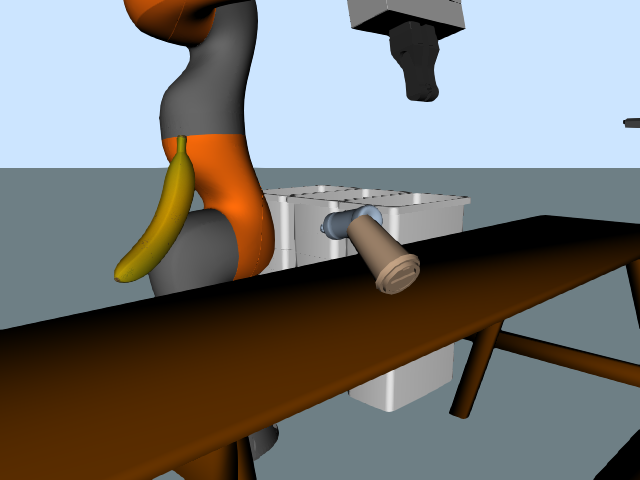

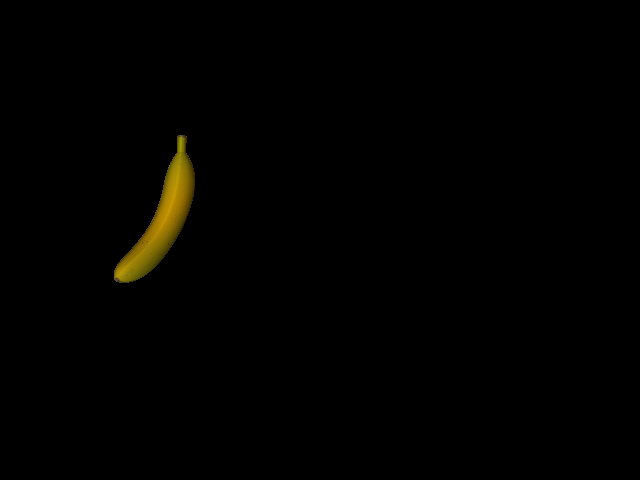

Label:  Banana


In [103]:
import PIL
dataset = RecyclingDataset(dataset_path)
i = np.random.randint(len(classes))
j = np.random.randint(len(dataset))
mask = dataset[j][1]["masks"][i]
label_idx = dataset[j][1]["labels"][i]
img = dataset[j][0] * 255
img_masked = img * mask
img_masked = np.array(img_masked, dtype=np.uint8)
img_masked = np.swapaxes(img_masked.T, 0, 1)
img_masked = PIL.Image.fromarray(img_masked)
img_masked.convert("RGB")
img = np.array(img, dtype=np.uint8)
img = np.swapaxes(img.T, 0, 1)
img = PIL.Image.fromarray(img)
img.convert("RGB")
display(img)
display(img_masked)
print("Label: ", classes[label_idx])

# Define the network

This cell is where the magic begins to happen.  We load a network that is pre-trained on the COCO dataset, then replace the network head with a new (untrained) network with the right number of outputs for our YCB recognition/segmentation task.

In [122]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Putting everything together

In [123]:
import utils

dataset = RecyclingDataset(dataset_path)

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# chop dataset down to 500 images for training to save time
dataset = torch.utils.data.Subset(dataset, indices[0:500])
data_train, data_test = torch.utils.data.random_split(dataset, [0.9, 0.1])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    data_train, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    data_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [124]:
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

num_classes = len(classes)

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 3 epochs, evaluating at the end of every epoch.

In [125]:
from engine import train_one_epoch, evaluate

num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/225]  eta: 0:17:57  lr: 0.000027  loss: 4.8526 (4.8526)  loss_classifier: 1.4191 (1.4191)  loss_box_reg: 0.3196 (0.3196)  loss_mask: 3.0196 (3.0196)  loss_objectness: 0.0862 (0.0862)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 4.7895  data: 0.0292
Epoch: [0]  [ 10/225]  eta: 0:16:16  lr: 0.000250  loss: 4.4184 (4.1913)  loss_classifier: 1.2898 (1.1254)  loss_box_reg: 0.4064 (0.3940)  loss_mask: 2.5604 (2.4311)  loss_objectness: 0.0656 (0.2233)  loss_rpn_box_reg: 0.0052 (0.0175)  time: 4.5431  data: 0.0238
Epoch: [0]  [ 20/225]  eta: 0:15:27  lr: 0.000473  loss: 1.7490 (2.8564)  loss_classifier: 0.4450 (0.7794)  loss_box_reg: 0.3888 (0.3928)  loss_mask: 0.9132 (1.5399)  loss_objectness: 0.0352 (0.1325)  loss_rpn_box_reg: 0.0049 (0.0119)  time: 4.5119  data: 0.0235
Epoch: [0]  [ 30/225]  eta: 0:14:52  lr: 0.000696  loss: 1.2854 (2.3247)  loss_classifier: 0.3988 (0.6545)  loss_box_reg: 0.4125 (0.4073)  loss_mask: 0.4114 (1.1595)  loss_objectness: 0.0157 (0.0940)  loss_rpn_b

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:33  model_time: 0.6555 (0.6555)  evaluator_time: 0.0038 (0.0038)  time: 0.6707  data: 0.0113
Test:  [49/50]  eta: 0:00:00  model_time: 0.6490 (0.6487)  evaluator_time: 0.0032 (0.0036)  time: 0.6662  data: 0.0105
Test: Total time: 0:00:33 (0.6633 s / it)
Averaged stats: model_time: 0.6490 (0.6487)  evaluator_time: 0.0032 (0.0036)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.977
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:32  model_time: 0.6333 (0.6333)  evaluator_time: 0.0028 (0.0028)  time: 0.6469  data: 0.0107
Test:  [49/50]  eta: 0:00:00  model_time: 0.6311 (0.6321)  evaluator_time: 0.0029 (0.0032)  time: 0.6482  data: 0.0103
Test: Total time: 0:00:32 (0.6460 s / it)
Averaged stats: model_time: 0.6311 (0.6321)  evaluator_time: 0.0029 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.829
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.874
 Average Re

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:32  model_time: 0.6353 (0.6353)  evaluator_time: 0.0029 (0.0029)  time: 0.6491  data: 0.0109
Test:  [49/50]  eta: 0:00:00  model_time: 0.6289 (0.6311)  evaluator_time: 0.0025 (0.0029)  time: 0.6453  data: 0.0103
Test: Total time: 0:00:32 (0.6444 s / it)
Averaged stats: model_time: 0.6289 (0.6311)  evaluator_time: 0.0025 (0.0029)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.917
 Average Re

In [126]:
torch.save(model.state_dict(), 'recycling_maskrcnn_model.pt')

If the model has already been trained and you'd like to load it:

In [ ]:
def load_model(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT, progress=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model

## Load model
MODEL_PATH = 'recycling_maskrcnn_model.pt'
num_classes = 4
model = load_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)

Let's look at what the model predicts in a test image

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [148]:
# pick one image from the test set
img, _ = data_test[np.random.randint(len(data_test))]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

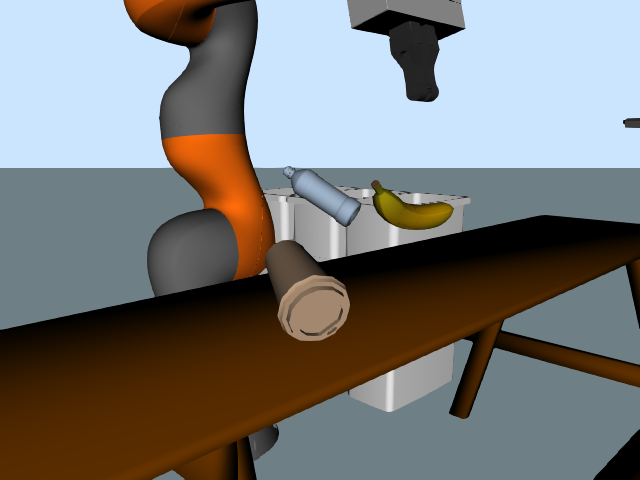

In [149]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

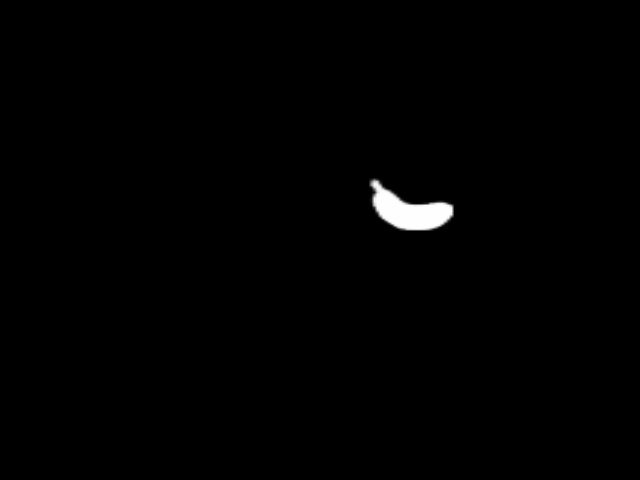

In [153]:
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy())